# 📈 Stock Portfolio Optimizer

Optimize a stock portfolio using **Modern Portfolio Theory** and **Monte Carlo Simulation**.

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 📥 Fetch stock data
def fetch_data(tickers, start='2020-01-01', end='2024-12-31'):
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)

    # Handle both single and multiple tickers
    if len(tickers) == 1:
        return data[['Adj Close']].rename(columns={'Adj Close': tickers[0]})
    else:
        return data['Adj Close']

tickers = input("Enter stock tickers (comma-separated): ").upper().split(',')
data = fetch_data(tickers)
data.tail()

Enter stock tickers (comma-separated):  AAPL,MSFT,GOOGL,AMZN


[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2024-12-23,254.655716,225.059998,194.171036,433.583038
2024-12-24,257.578674,229.050003,195.647552,437.647369
2024-12-26,258.396667,227.050003,195.138748,436.432068
2024-12-27,254.974930,223.750000,192.305435,428.881104
2024-12-30,251.593079,221.300003,190.789047,423.202911


In [4]:
# 📊 Calculate daily and annual returns
def calculate_returns(data):
    daily_returns = data.pct_change().dropna()
    annual_returns = daily_returns.mean() * 252
    return daily_returns, annual_returns

daily_returns, annual_returns = calculate_returns(data)
cov_matrix = daily_returns.cov() * 252
annual_returns

Ticker
AAPL     0.299545
AMZN     0.234575
GOOGL    0.259848
MSFT     0.250702
dtype: float64

In [5]:
# 🧪 Monte Carlo Simulation
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std_dev

def simulate_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.0):
    results = {'Returns': [], 'Volatility': [], 'Sharpe': [], 'Weights': []}
    num_assets = len(mean_returns)

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - risk_free_rate) / vol

        results['Returns'].append(ret)
        results['Volatility'].append(vol)
        results['Sharpe'].append(sharpe)
        results['Weights'].append(weights)

    return pd.DataFrame(results)

df = simulate_portfolios(10000, annual_returns, cov_matrix)
df.head()

,Returns,Volatility,Sharpe,Weights
0,0.265596,0.282095,0.941512,"[0.28935120714788837, 0.11143314818904307, 0.2..."
1,0.250878,0.300334,0.835329,"[0.01917405425271609, 0.3474508326883319, 0.52..."
2,0.260708,0.285801,0.912203,"[0.2796190885041139, 0.31085882043741697, 0.14..."
3,0.251882,0.304277,0.827807,"[0.14228311167760682, 0.5366396484412463, 0.31..."
4,0.258181,0.297451,0.867978,"[0.2760318095516084, 0.4903579082593596, 0.208..."


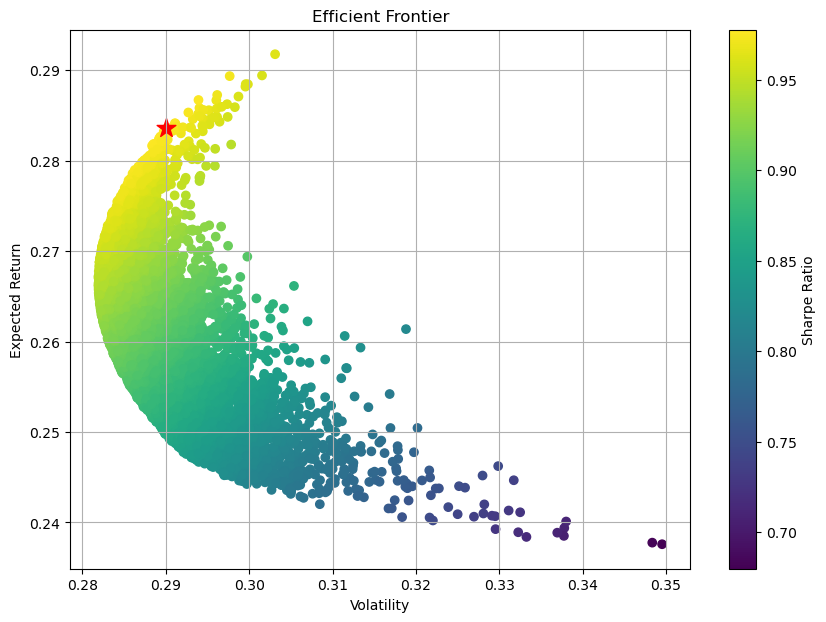

In [6]:
# 📈 Plot Efficient Frontier
def plot_efficient_frontier(df):
    max_sharpe = df.loc[df['Sharpe'].idxmax()]
    plt.figure(figsize=(10, 7))
    plt.scatter(df['Volatility'], df['Returns'], c=df['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe['Volatility'], max_sharpe['Returns'], c='red', marker='*', s=200)
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Expected Return')
    plt.grid(True)
    plt.show()

plot_efficient_frontier(df)

In [7]:
# Modify simulation to respect a max allocation constraint
def simulate_portfolios_with_constraints(num_portfolios, mean_returns, cov_matrix, risk_free_rate=0.0, max_allocation=0.4):
    results = {'Returns': [], 'Volatility': [], 'Sharpe': [], 'Weights': []}
    num_assets = len(mean_returns)

    for _ in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

        # Apply constraint: reject portfolio if any weight > max_allocation
        if any(weights > max_allocation):
            continue

        ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - risk_free_rate) / vol

        results['Returns'].append(ret)
        results['Volatility'].append(vol)
        results['Sharpe'].append(sharpe)
        results['Weights'].append(weights)

    return pd.DataFrame(results)

# Example: Allow max 40% in any single stock
df = simulate_portfolios_with_constraints(10000, annual_returns, cov_matrix, max_allocation=0.4)
df.head()

,Returns,Volatility,Sharpe,Weights
0,0.265528,0.282820,0.938861,"[0.32571425445117264, 0.20724759363839146, 0.2..."
1,0.252024,0.292159,0.862625,"[0.0788412437373363, 0.3508051310420791, 0.342..."
2,0.266104,0.283421,0.938903,"[0.26492201140996413, 0.04446717272817748, 0.3..."
3,0.250552,0.292403,0.856874,"[0.08816294712759039, 0.391175979605025, 0.202..."
4,0.249946,0.292402,0.854802,"[0.039662110445965564, 0.34367343234928976, 0...."


In [8]:
# Save optimal portfolio allocation to a CSV file
max_sharpe = df.loc[df['Sharpe'].idxmax()]
portfolio = pd.DataFrame({
    'Ticker': tickers,
    'Allocation (%)': [round(w * 100, 2) for w in max_sharpe['Weights']]
})
portfolio.to_csv('optimal_portfolio.csv', index=False)
print("Optimal portfolio saved as 'optimal_portfolio.csv'")
portfolio

Optimal portfolio saved as 'optimal_portfolio.csv'


,Ticker,Allocation (%)
0,AAPL,39.99
1,MSFT,0.80
2,GOOGL,35.40
3,AMZN,23.81


Enter the risk-free rate (e.g., 0.02 for 2%):  0.048


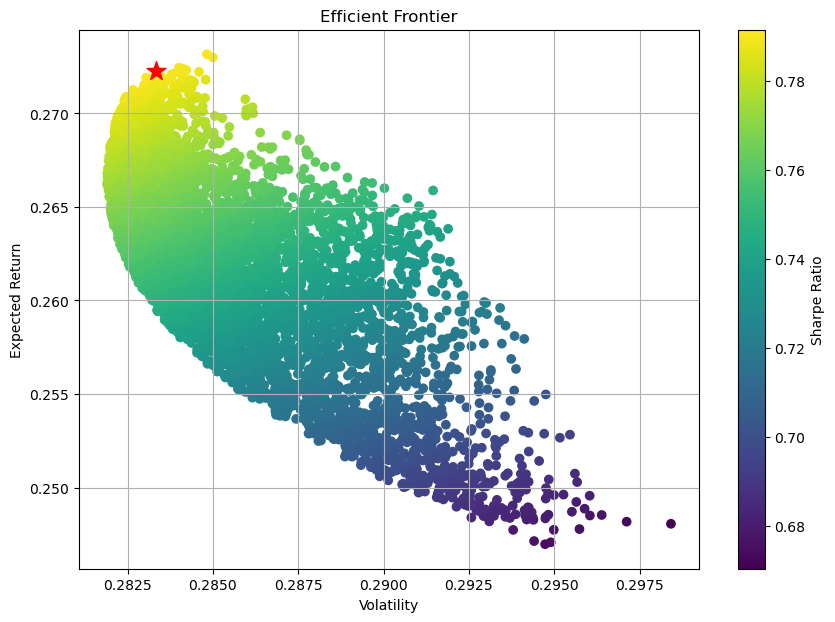

In [9]:
# User-defined risk-free rate
risk_free_rate = float(input("Enter the risk-free rate (e.g., 0.02 for 2%): "))
df = simulate_portfolios_with_constraints(10000, annual_returns, cov_matrix, risk_free_rate, max_allocation=0.4)
plot_efficient_frontier(df)

In [10]:
# ⭐ Display Optimal Portfolio
max_sharpe = df.loc[df['Sharpe'].idxmax()]
print("\nOptimal Portfolio Allocation:")
for t, w in zip(tickers, max_sharpe['Weights']):
    print(f"{t}: {round(w*100, 2)}%")

print(f"\nExpected Annual Return: {round(max_sharpe['Returns']*100, 2)}%")
print(f"Volatility: {round(max_sharpe['Volatility']*100, 2)}%")
print(f"Sharpe Ratio: {round(max_sharpe['Sharpe'], 2)}")


Optimal Portfolio Allocation:
AAPL: 39.64%
MSFT: 4.01%
GOOGL: 31.35%
AMZN: 25.0%

Expected Annual Return: 27.23%
Volatility: 28.33%
Sharpe Ratio: 0.79
